This is the pipeline of MonoSLAM (Real-Time Single Camera SLAM). The concepts and techniques used here are not only fundamental to SLAM but also applicable to other domains, such as multi-view geometry. Let's get started and dive into the exciting world of SLAM!

In [1]:
import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from IPython.display import clear_output

Let's first define some useful classes - we will need to keep track of intrinsic and extrinsic camera parameters and every frame:

In [2]:
class Frame(object):
    # global
    idx = 0
    last_kps, last_des, last_pose = None, None, None

    # for indivisual frame, keep track of info from last frame
    def __init__(self, image):
        Frame.idx += 1

        self.image = image
        self.idx   = Frame.idx
        self.last_kps  = Frame.last_kps
        self.last_des  = Frame.last_des
        self.last_pose = Frame.last_pose

class Camera(object):
    W, H, F = 960, 540, 270
    P = np.eye(3)

First, we want to extract keypoints from each frame. ORB (Oriented FAST and Rotated BRIEF) features consist of two components: keypoints and descriptors. The keypoints, known as "Oriented FAST," are an improved version of FAST corners, while the descriptors are referred to as BRIEF.

In [3]:
# TODO:
def extract_points(frame):
    orb = cv2.ORB_create()

    # Convert frame.image to grayscale
    image = cv2.cvtColor(frame.image, cv2.COLOR_BGR2GRAY)

    # Detect corners using cv2.goodFeaturesToTrack()
    pts = cv2.goodFeaturesToTrack(image, 3000, qualityLevel=0.01, minDistance=3)

    # Extract features using cv2.KeyPoint()
    kps = [cv2.KeyPoint(x=pt[0][0], y=pt[0][1], size=20) for pt in pts]

    # Compute the features of the corners using the compute function from the ORB module
    # This yields two outputs: kps and des
    kps, des = orb.compute(image, kps)

    # Convert kps to numpy array
    kps = np.array([(kp.pt[0], kp.pt[1]) for kp in kps])

    return kps, des

Then, we need match the extracted keypoints between consecutive frames. Here, the match_points function will align the keypoints of the current frame with those of the previous frame. This step enables us to understand the camera movements in the 3D scene and thus construct the environment later.

In [4]:
# TODO: 
def match_points(frame):
    # Create a matcher called bfmatch using cv2.BFMatcher
    # Set normType to cv2.NORM_HAMMING for ORB descriptors
    # Set crossCheck to False (default value)
    bfmatch = cv2.BFMatcher(cv2.NORM_HAMMING)

    # Retrieve the top 2 best matches for each keypoint
    matches = bfmatch.knnMatch(frame.curr_des, frame.last_des, k=2)

    match_kps = []
    idx1, idx2 = [], []

    # Iterate over the matches and filter based on distance ratio
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            idx1.append(m.queryIdx)
            idx2.append(m.trainIdx)

            p1 = frame.curr_kps[m.queryIdx]
            p2 = frame.last_kps[m.trainIdx]
            match_kps.append((p1, p2))

    # Update keypoints to include only the matched keypoints
    frame.curr_kps = frame.curr_kps[idx1]
    frame.last_kps = frame.last_kps[idx2]

    return match_kps

After implementing the extract-match, you can visualize the movements of keypoints now! upload some videos your like on colab via the "Files" icon in the left colomn -> upload to session storage. we have provided you with some test videos that can be found in the same folder. Then, run the code below.

In [5]:
# helper function to plot the motion trajectory of keypoints, you can follow these steps:
def draw_points(frame):
    for kp1, kp2 in zip(frame.curr_kps, frame.last_kps):
        u1, v1 = int(kp1[0]), int(kp1[1])
        u2, v2 = int(kp2[0]), int(kp2[1])
        cv2.circle(frame.image, (u1, v1), color=(0,0,255), radius=3)
        cv2.line(frame.image, (u1, v1), (u2, v2), color=(255,0,0))
    return None

In [ ]:
cap = cv2.VideoCapture("road.mp4")  # TODO: change the file name here to match your uploaded file
while cap.isOpened() :
    ret, image = cap.read()
    frame = Frame(image)

    if ret:
        frame.curr_kps, frame.curr_des = extract_points(frame)
        Frame.last_kps, Frame.last_des = frame.curr_kps, frame.curr_des
        if frame.idx > 1:
          match_kps = match_points(frame)
          draw_points(frame)
    else:
        break
    clear_output(wait=True)
    cv2_imshow(frame.image)
    k = cv2.waitKey(33) & 0xFF
    if k == 27:
      cv2.destroyAllWindows()

Although the current approach is satisfactory, there is room for improvement. Notice that there are some ourliers in the video. We can enhance the estimation process by leveraging the RANSAC (RAndom SAmple Consensus) algorithm, which enable us to mitigate the influence of noise and outliers

RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. Each iteration performs the following tasks:

1. Select min_samples random samples from the original data and check whether the set of data is valid (see is_data_valid).

2. Estimate a model to the random subset (model_cls.estimate(*data[random_subset]) and check whether the estimated model is valid (see is_model_valid).

3. Classify all data as inliers or outliers by calculating the residuals to the estimated model (model_cls.residuals(*data)) - all data samples with residuals smaller than the residual_threshold are considered as inliers.

4. Save estimated model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has less sum of residuals.

These steps are performed either a maximum number of times or until one of the special stop criteria are met. The final model is estimated using all inlier samples of the previously determined best model.

To make your life easier, we are going to use the consistency check (model.estimate) in scikit-image for keypoints. We prefer essential matrix over the homography when dealing with general camera motion because it can model non-planar motion, allowing for accurate pose estimation and 3D reconstruction. we have provide a skeleton for you, and your job is to fill the iterative algorithm described above in ransac().

In [6]:
from skimage.transform import EssentialMatrixTransform

In [7]:
# normalize the coordinates of keypoints using camera intrinsic parameters
def normalize_coordinates(K, keypoints):
    K_inv = np.linalg.inv(K)
    add_ones = lambda x: np.concatenate([x, np.ones((x.shape[0], 1))], axis=1)
    normalized_pts = np.dot(K_inv, add_ones(keypoints).T).T[:, :2]
    return normalized_pts

def noice_reduce(match_kps):
    K = np.array([[Camera.F, 0, Camera.W//2],
                  [0, Camera.F, Camera.H//2],
                  [0, 0, 1]])
    matched_keypoints = np.array(match_kps)
    normalized_curr_kps = normalize_coordinates(K, matched_keypoints[:, 0])
    normalized_last_kps = normalize_coordinates(K, matched_keypoints[:, 1])

    # Find the inlier data and their corresponding essential matrix.
    model, inliers = ransac((normalized_last_kps, normalized_curr_kps),
                            EssentialMatrixTransform,
                            min_samples=8,
                            residual_threshold=0.005,
                            max_trials=200)

    frame.curr_kps = frame.curr_kps[inliers]
    frame.last_kps = frame.last_kps[inliers]


# TODO: implement the iterative part
def ransac(data, model_class, min_samples, residual_threshold, max_trials):
    best_inlier_num = 0
    best_inlier_residuals_sum = np.inf
    best_inliers = []
    num_samples = len(data[0]) # total number of samples
    # estimate model for current random sample set
    model = model_class()
    num_trials = 0
    rng = np.random.default_rng()
    
    # max_trials can be updated inside the loop, so this cannot be a for-loop
    while num_trials < max_trials:
        num_trials += 1

        spl_idxs = rng.choice(num_samples, min_samples, replace=False)
        # do sample selection according data pairs
        samples = [d[spl_idxs] for d in data]

        success = model.estimate(*samples)
        # backwards compatibility
        if success is not None and not success:
            continue

        residuals = np.abs(model.residuals(*data))
        # consensus set / inliers
        inliers = residuals < residual_threshold
        residuals_sum = residuals.dot(residuals)

        # choose as new best model if number of inliers is maximal
        inliers_count = np.count_nonzero(inliers)
        if (
            # more inliers
            inliers_count > best_inlier_num
            # same number of inliers but less "error" in terms of residuals
            or (inliers_count == best_inlier_num
                and residuals_sum < best_inlier_residuals_sum)):
            best_inlier_num = inliers_count
            best_inlier_residuals_sum = residuals_sum
            best_inliers = inliers

    # estimate final model using all inliers
    if any(best_inliers):
        # select inliers for each data array
        data_inliers = [d[best_inliers] for d in data]
        model.estimate(*data_inliers)
    else:
        model = None
        best_inliers = None

    return model, best_inliers

Now, if you run the code below, you should observe a notable reduction in noise!

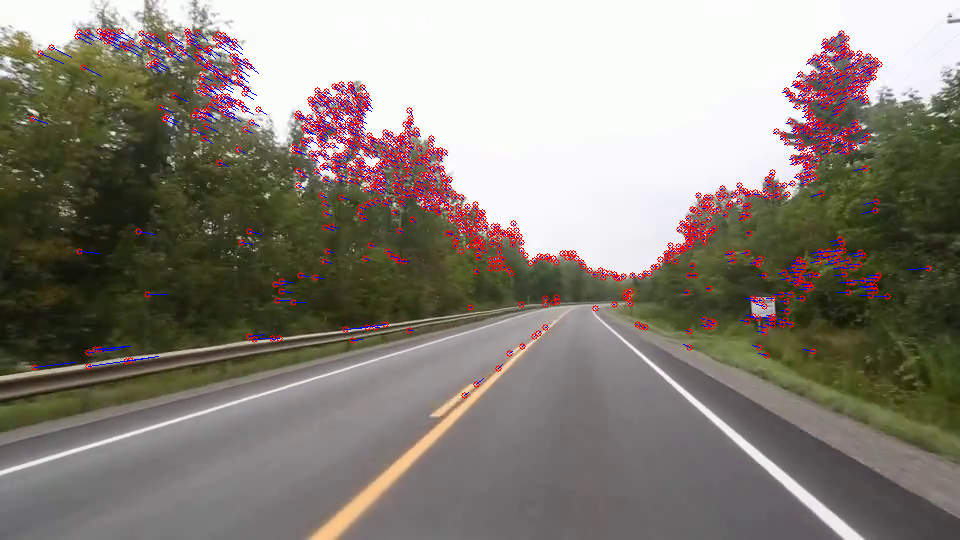

In [8]:
cap = cv2.VideoCapture("road.mp4")  # TODO: change the file name here to match your uploaded file
while cap.isOpened() :
    ret, image = cap.read()
    frame = Frame(image)

    if ret:
        frame.curr_kps, frame.curr_des = extract_points(frame)
        Frame.last_kps, Frame.last_des = frame.curr_kps, frame.curr_des
        if frame.idx > 1:
          match_kps = match_points(frame)
          noice_reduce(match_kps)
          draw_points(frame)
    else:
        break
    clear_output(wait=True)
    cv2_imshow(frame.image)
    k = cv2.waitKey(33) & 0xFF
    if k == 27:
      cv2.destroyAllWindows()

Up to this point, you have gain a solid understanding of how to match points in a 2D space. Now, let's move to the conceptual part. You will practice how to transform these 2D points into 3D using the best model obtained from ransac(). This will enable you later to construct the complete 3D scene.

# New Section